In [1]:
import numpy as np
import copy
import pandas as pd
from skimage.feature import peak_local_max
import os
import copy

%matplotlib inline
import matplotlib.pyplot as plt

#CODATA 2017
kB = 1.38064903E-23  #J/K
Na = 6.022140758E+23 #1/mol

In [2]:
import feasst

In [3]:
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import FormatStrFormatter

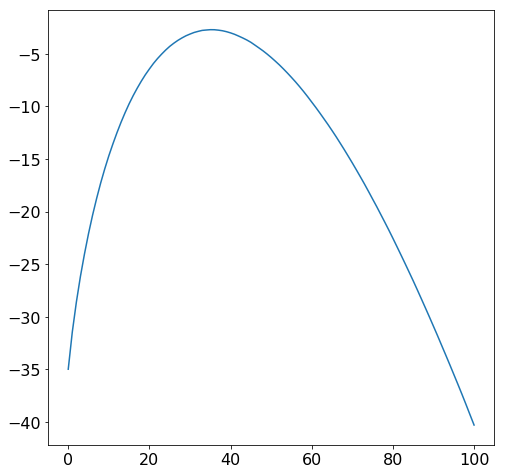

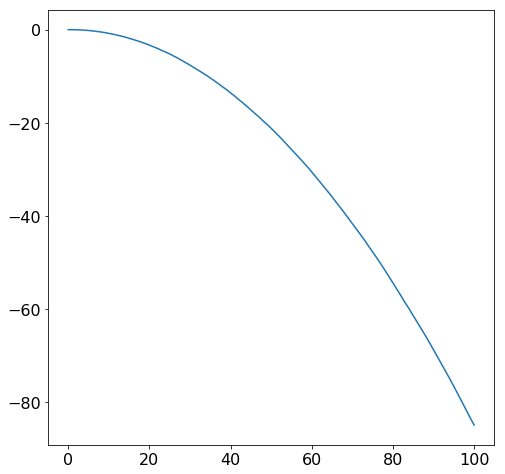

In [88]:
def read_feasst_restarts(stub):
    space = feasst.Space(stub+"space")
    boxLength = [space.boxLength(0),space.boxLength(1),space.boxLength(2)]

    criteria = feasst.CriteriaWLTMMC(stub+"criteria")
    beta = criteria.beta()
    lnZ = np.log(criteria.activ(0))
    volume = boxLength[0]*boxLength[1]*boxLength[2]

    nMin = int(np.ceil(criteria.mMin()))
    nMax = int(np.floor(criteria.mMax()))
    
    # Return FEASST data as Python lists to enable easier appending
    N = [x for x in range(nMin,nMax+1)]
    lnPi = [x for x in np.array(criteria.lnPIdouble())]
    bins = len(lnPi)
    energy = [ criteria.pe(i).sumDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)]
    energy2 = [ criteria.pe(i).sumSqDble()/criteria.pe(i).nValues() if criteria.pe(i).nValues()!=0 else 0. for i in range(0,bins)]

    return N, lnPi, energy, energy2, beta, lnZ

def append_data(N0,array0,N1,array1,smooth_type="mean"):
    #Splices array1 onto array0, with smoothing
    N_out = [x for x in N0]
    array_out = [x for x in array0]
    ref_min = N1[0]
    ref_max = N0[-1]
    for Ni in N1[1:]:  #start with the second position [Bayes P]
        if Ni <= ref_max:
            if smooth_type == "mean":
                delta = 0.5*( (array0[Ni]-array0[Ni-1]) + (array1[Ni-ref_min]-array1[Ni-ref_min-1])  )
            else:
                raise Exception("Unknown smoothing type: "+smooth_type)
            array_out[Ni] = array_out[Ni-1]+delta
        else:
            delta = (array1[Ni-ref_min]-array1[Ni-ref_min-1])
            array_out.append(array_out[-1]+delta)
            N_out.append(N_out[-1]+1)
    return N_out, array_out

def splice_window_data(source,prefix):
    input_files = [ x for x in os.listdir(source) if (prefix in x and "space" in x and "bak" not in x and "rng" not in x) ]
    windows = len(input_files)

    for i in range(windows):
        stub = source+ "/" + prefix+str(i)
        N_w, lnPi_w, energy_w, energy2_w, beta_w, lnZ0_w = read_feasst_restarts(stub)
        if i == 0:
            beta = beta_w
            lnZ = lnZ0_w
            Nmin = N_w[0]
            Nmax = N_w[-1]
            lnPi_master = copy.copy(lnPi_w)
            N_master = copy.copy(N_w)
            energy_master = copy.copy(energy_w)
            energy2_master = copy.copy(energy2_w)
        else: #assumes overlap = 1 [need to generalize]
            ref_min = N_w[0]
            ref_max = N_master[-1]
            N_old = [x for x in N_master]
            N_master, lnPi_master = append_data(N_master,lnPi_master,N_w,lnPi_w)
            N_tmp, energy_master = append_data(N_old,energy_master,N_w,energy_w)
            N_tmp, energy2_master = append_data(N_old,energy2_master,N_w,energy2_w)
            #print(len(lnPi_master),len(energy_master))
        #print('Reading data:', i, Nmin, Nmax)

    # Convert to NumPy Arrays
    N_master = np.array(N_master)
    lnPi_master = np.array(lnPi_master)
    energy_master = np.array(energy_master)
    energy2_master = np.array(energy2_master)
    
    # Normalize lnPi
    lnPi_master = lnPi_master - max(lnPi_master)
    lnPi_master = lnPi_master - np.log(sum(np.exp(lnPi_master)))
    # Adjust Energy so that E(Nmin) = 0
    energy2_master = energy2_master - 2.*energy_master[0]*energy_master + energy_master[0]**2
    energy_master = energy_master - energy_master[0]

    return N_master, lnPi_master, energy_master, beta, lnZ


#source = "/home/local/NIST/dsideriu/Workstation_Research/Monte_Carlo/my_FEASST/multiprocessing/tmp/"
source = "/home/local/NIST/dsideriu/Workstation_Research/Monte_Carlo/my_FEASST/multiprocessing/overlap_4/tmp/"
stub = "rst_core"

N, lnPi, energy, eta, lnZ = splice_window_data(source,"rst_core")

fig = plt.figure(figsize=(8,8))
plt.plot(N,lnPi)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.plot(N,energy)
plt.show()

#for i in N:
#    print(i,lnPi[i],energy[i],energy2[i])

In [38]:
N0, lnPi0, energy0, energy2, beta, lnZ = read_feasst_restarts(source+'rst_core0')
N1, lnPi1, energy1, energy2, beta, lnZ = read_feasst_restarts(source+'rst_core1')

lnPi_master = [x for x in lnPi0]

lnPi_tmp = [x for x in lnPi_master]

ref_min = N1[0]
ref_max = N0[-1]
for Ni in N1[1:]:  #start with the second 
    #if Ni == ref_min:
    #    #print(Ni,lnPi_master[Ni])
    #    continue
    #elif Ni <= ref_max:
    if Ni <= ref_max:
        #print(Ni,lnPi_tmp[Ni])
        #delta0 = (lnPi_tmp[Ni]-lnPi_tmp[Ni-1])
        #delta1 = (lnPi1[Ni-ref_min]-lnPi1[Ni-ref_min-1])
        delta = 0.5*( (lnPi_tmp[Ni]-lnPi_tmp[Ni-1]) + (lnPi1[Ni-ref_min]-lnPi1[Ni-ref_min-1])  )
        lnPi_master[Ni] = lnPi_master[Ni-1]+delta
    else:
        delta = (lnPi1[Ni-ref_min]-lnPi1[Ni-ref_min-1])
        lnPi_master.append(lnPi_master[-1]+delta)
    print(Ni,delta,lnPi_master[Ni])


51 -0.3437177828398219 -5.688648943510777
52 -0.3552983772535603 -6.043947320764337
53 -0.38063520683656915 -6.424582527600906
54 -0.3987631992215763 -6.823345726822483
55 -0.4151831271697186 -7.238528853992202
56 -0.4264488283762642 -7.664977682368466
57 -0.45097035254874385 -8.11594803491721
58 -0.4693259415364528 -8.585273976453664
59 -0.48904883702725055 -9.074322813480915
60 -0.5119524958316859 -9.586275309312601
61 -0.5082455562112074 -10.094520865523808
62 -0.5311387288357432 -10.62565959435955
63 -0.5460051978194151 -11.171664792178966
64 -0.5461769930835576 -11.717841785262523
65 -0.5718057330852107 -12.289647518347735
66 -0.5825945430723678 -12.872242061420103
67 -0.6086048937818536 -13.480846955201956
68 -0.6144530907268653 -14.095300045928822
69 -0.6339179254046972 -14.729217971333519
70 -0.6405372398481575 -15.369755211181676
71 -0.6614476475794522 -16.031202858761127
72 -0.6712688353817136 -16.70247169414284
73 -0.6800771386682314 -17.38254883281107
